https://www.kaggle.com/diegosiebra/neural-network-model-for-house-prices-keras

# <center> A Neural Network Model for House Prices

The purpose of this notebook is to build a model (Deep Neural Network) with Keras over Tensorflow. We will see the differents steps to do that. This notebook is split in several parts:

- I.    Importation & Devices Available
- II.   Outliers
- III.  Preprocessing
- IV.   KerasRegressor for Contiunuous features
- V.    Predictions


# <center> I. Importation & Devices Available

In [1]:
import os
import tensorflow as tf

In this tutorial our data is composed to 1460 row with 81 features. 38 continuous features and 43 categorical features. As exposed in the introduction we will use onlly the continuous features to build our first model.

Here the objective is to predict the House Prices. In this case we have a regression model to build.
So our first data we will contain 37 features to explain the 'SalePrice'. We can see the list of features that we will use to build our first model.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

train = pd.read_csv('./input/train.csv')
print('Shape of the train data with all features:', train.shape)
train = train.select_dtypes(exclude=['object'])
print("")
print('Shape of the train data with numerical features:', train.shape)
train.drop('Id',axis = 1, inplace = True)
train.fillna(0,inplace=True)

test = pd.read_csv('./input/test.csv')
test = test.select_dtypes(exclude=['object'])
ID = test.Id
test.fillna(0,inplace=True)
test.drop('Id',axis = 1, inplace = True)

print("")
print("List of features contained our dataset:",list(train.columns))

Shape of the train data with all features: (1460, 81)

Shape of the train data with numerical features: (1460, 38)

List of features contained our dataset: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


# <center> II. Outliers

In this small part we will isolate the outliers with an IsolationForest (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html). I tried with and without this step and I had a better performance removing these rows.

I haven't analysed the test set but I suppose that our train set looks like more at our data test without these outliers.


In [3]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 139
Number of rows without outliers: 1321


In [4]:
train.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
5,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,40,30,0,320,0,0,700,10,2009,143000
6,20,75.0,10084,8,5,2004,2005,186.0,1369,0,...,255,57,0,0,0,0,0,8,2007,307000
7,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,90,0,205,0,0,0,0,4,2008,129900
8,190,50.0,7420,5,6,1939,1950,0.0,851,0,...,0,4,0,0,0,0,0,1,2008,118000
9,20,70.0,11200,5,5,1965,1965,0.0,906,0,...,0,0,0,0,0,0,0,2,2008,129500


# <center> III. Preprocessing

To rescale our data we will use the fonction MinMaxScaler of Scikit-learn. I am wondering if it is not interesting to use the same MinMaxScaler for Train and Test !

In [5]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('SalePrice')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice).reshape((1321,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.235294,0.207668,0.062802,0.625,0.428571,0.953488,0.883333,0.12250,0.416274,0.0,...,0.000000,0.167582,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.403057
1,0.000000,0.255591,0.072904,0.500,0.857143,0.744186,0.433333,0.00000,0.576651,0.0,...,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.340220
2,0.235294,0.217252,0.087396,0.625,0.428571,0.937984,0.866667,0.10125,0.286557,0.0,...,0.000000,0.115385,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.437966
3,0.294118,0.191693,0.072464,0.625,0.428571,0.271318,0.333333,0.00000,0.127358,0.0,...,0.000000,0.096154,0.824242,0.0,0.0,0.0,0.0,0.090909,0.00,0.243639
4,0.235294,0.268371,0.113835,0.750,0.428571,0.930233,0.833333,0.21875,0.386203,0.0,...,0.260870,0.230769,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.499638


In [6]:
mat_train

matrix([[6.00000e+01, 6.50000e+01, 8.45000e+03, ..., 2.00000e+00,
         2.00800e+03, 2.08500e+05],
        [2.00000e+01, 8.00000e+01, 9.60000e+03, ..., 5.00000e+00,
         2.00700e+03, 1.81500e+05],
        [6.00000e+01, 6.80000e+01, 1.12500e+04, ..., 9.00000e+00,
         2.00800e+03, 2.23500e+05],
        ...,
        [2.00000e+01, 8.50000e+01, 1.31750e+04, ..., 2.00000e+00,
         2.01000e+03, 2.10000e+05],
        [2.00000e+01, 6.80000e+01, 9.71700e+03, ..., 4.00000e+00,
         2.01000e+03, 1.42125e+05],
        [2.00000e+01, 7.50000e+01, 9.93700e+03, ..., 6.00000e+00,
         2.00800e+03, 1.47500e+05]])

In [7]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns
feature_cols = FEATURES

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]

In [8]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
727,0.352941,0.239617,0.074221,0.375,0.428571,0.674419,0.283333,0.00,0.235849,0.325645,...,0.092391,0.000000,0.0,0.0,0.0,0.0,0.0,0.818182,0.00,0.233166
479,0.000000,0.000000,0.100440,0.250,0.428571,0.713178,0.366667,0.00,0.353774,0.000000,...,0.293478,0.000000,0.0,0.0,0.0,0.0,0.0,0.272727,0.50,0.176730
240,0.058824,0.226837,0.049188,0.375,0.571429,0.465116,0.083333,0.00,0.237618,0.084803,...,0.000000,0.068681,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,0.198257
422,0.294118,0.252396,0.071850,0.375,0.714286,0.480620,0.750000,0.14,0.227594,0.000000,...,0.228261,0.000000,0.0,0.0,0.0,0.0,0.0,0.454545,0.25,0.258766
49,0.352941,0.191693,0.051243,0.375,0.428571,0.581395,0.083333,0.00,0.226415,0.000000,...,0.000000,0.137363,0.0,0.0,0.0,0.0,0.0,0.090909,0.25,0.220366


# <center> IV. Deep Neural Network for continuous features

With tf.contrib.learn it is very easy to implement a Deep Neural Network. In our example we will have 5 hidden layers with repsectly 200, 100, 50, 25 and 12 units and the function of activation will be Relu.

The optimizer used in our case is an AdaDelta  optimizer.

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

seed = 7
np.random.seed(seed)

# Model
model = Sequential()
model.add(Dense(200, input_dim=36, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adadelta())

feature_cols = training_set[FEATURES]
labels = training_set[LABEL].values

model.fit(np.array(feature_cols), np.array(labels), epochs=100, batch_size=10)

Train on 885 samples
Epoch 1/100
885/885 [==============================] - 1s 1ms/sample - loss: 0.1232
Epoch 2/100
885/885 [==============================] - 0s 217us/sample - loss: 0.1230
Epoch 3/100
885/885 [==============================] - 0s 216us/sample - loss: 0.1228
Epoch 4/100
885/885 [==============================] - 0s 210us/sample - loss: 0.1227
Epoch 5/100
885/885 [==============================] - 0s 214us/sample - loss: 0.1225
Epoch 6/100
885/885 [==============================] - 0s 215us/sample - loss: 0.1223
Epoch 7/100
885/885 [==============================] - 0s 211us/sample - loss: 0.1220
Epoch 8/100
885/885 [==============================] - 0s 217us/sample - loss: 0.1218
Epoch 9/100
885/885 [==============================] - 0s 210us/sample - loss: 0.1215
Epoch 10/100
885/885 [==============================] - 0s 210us/sample - loss: 0.1212
Epoch 11/100
885/885 [==============================] - 0s 212us/sample - loss: 0.1209
Epoch 12/100
885/885 [===========

885/885 [==============================] - 0s 220us/sample - loss: 0.0596
Epoch 95/100
885/885 [==============================] - 0s 211us/sample - loss: 0.0585
Epoch 96/100
885/885 [==============================] - 0s 209us/sample - loss: 0.0573
Epoch 97/100
885/885 [==============================] - 0s 210us/sample - loss: 0.0562
Epoch 98/100
885/885 [==============================] - 0s 215us/sample - loss: 0.0551
Epoch 99/100
885/885 [==============================] - 0s 212us/sample - loss: 0.0539
Epoch 100/100
885/885 [==============================] - 0s 210us/sample - loss: 0.0528


In [10]:
# Evaluation on the test set created by train_test_split
model.evaluate(np.array(feature_cols), np.array(labels))

885/885 [==============================] - 0s 90us/sample - loss: 0.0523


0.05225174141216413

In [11]:
# Predictions
feature_cols_test = testing_set[FEATURES]
labels_test = testing_set[LABEL].values

y = model.predict(np.array(feature_cols_test))
predictions = list(itertools.islice(y, testing_set.shape[0]))


In [12]:
predictions

[array([0.13429254], dtype=float32),
 array([0.13405658], dtype=float32),
 array([0.13274135], dtype=float32),
 array([0.14088906], dtype=float32),
 array([0.13602194], dtype=float32),
 array([0.15480313], dtype=float32),
 array([0.13339458], dtype=float32),
 array([0.13667177], dtype=float32),
 array([0.13692881], dtype=float32),
 array([0.15126154], dtype=float32),
 array([0.14415842], dtype=float32),
 array([0.1399683], dtype=float32),
 array([0.14072403], dtype=float32),
 array([0.15367255], dtype=float32),
 array([0.13956986], dtype=float32),
 array([0.14780407], dtype=float32),
 array([0.13368721], dtype=float32),
 array([0.13389595], dtype=float32),
 array([0.14223136], dtype=float32),
 array([0.14076132], dtype=float32),
 array([0.13800888], dtype=float32),
 array([0.14666297], dtype=float32),
 array([0.1329302], dtype=float32),
 array([0.1440997], dtype=float32),
 array([0.14258693], dtype=float32),
 array([0.15062712], dtype=float32),
 array([0.1379801], dtype=float32),
 arra

In [13]:
print(y)

[[0.13429254]
 [0.13405658]
 [0.13274135]
 [0.14088906]
 [0.13602194]
 [0.15480313]
 [0.13339458]
 [0.13667177]
 [0.13692881]
 [0.15126154]
 [0.14415842]
 [0.1399683 ]
 [0.14072403]
 [0.15367255]
 [0.13956986]
 [0.14780407]
 [0.13368721]
 [0.13389595]
 [0.14223136]
 [0.14076132]
 [0.13800888]
 [0.14666297]
 [0.1329302 ]
 [0.1440997 ]
 [0.14258693]
 [0.15062712]
 [0.1379801 ]
 [0.14840183]
 [0.13842848]
 [0.14575832]
 [0.13670039]
 [0.13589753]
 [0.14188473]
 [0.13229077]
 [0.13419959]
 [0.13899255]
 [0.13398752]
 [0.14556354]
 [0.14633574]
 [0.1281466 ]
 [0.1403951 ]
 [0.13058172]
 [0.14358696]
 [0.14722723]
 [0.136974  ]
 [0.1361501 ]
 [0.15093173]
 [0.13210957]
 [0.14212653]
 [0.13425918]
 [0.15365335]
 [0.15416718]
 [0.14890023]
 [0.13839081]
 [0.14260042]
 [0.14341244]
 [0.14327052]
 [0.14822751]
 [0.13506739]
 [0.14246544]
 [0.136247  ]
 [0.14324747]
 [0.14204143]
 [0.1341504 ]
 [0.14734991]
 [0.14115275]
 [0.13662255]
 [0.1413156 ]
 [0.13028453]
 [0.14780803]
 [0.14763981]
 [0.13

# <center> V. Predictions and submission

Let's go to prepare our first submission ! Data Preprocessed: checked ! Outlier excluded: checked ! Model built: : checked! Next step: Used our model to make the predictions with the data set Test. And add one graphic to see the difference between the reality and the predictions.

In [14]:
predictions = prepro_y.inverse_transform(np.array(predictions).reshape(436,1))

In [16]:
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = [COLUMNS]).loc[:, ['SalePrice']].values.reshape(-1)

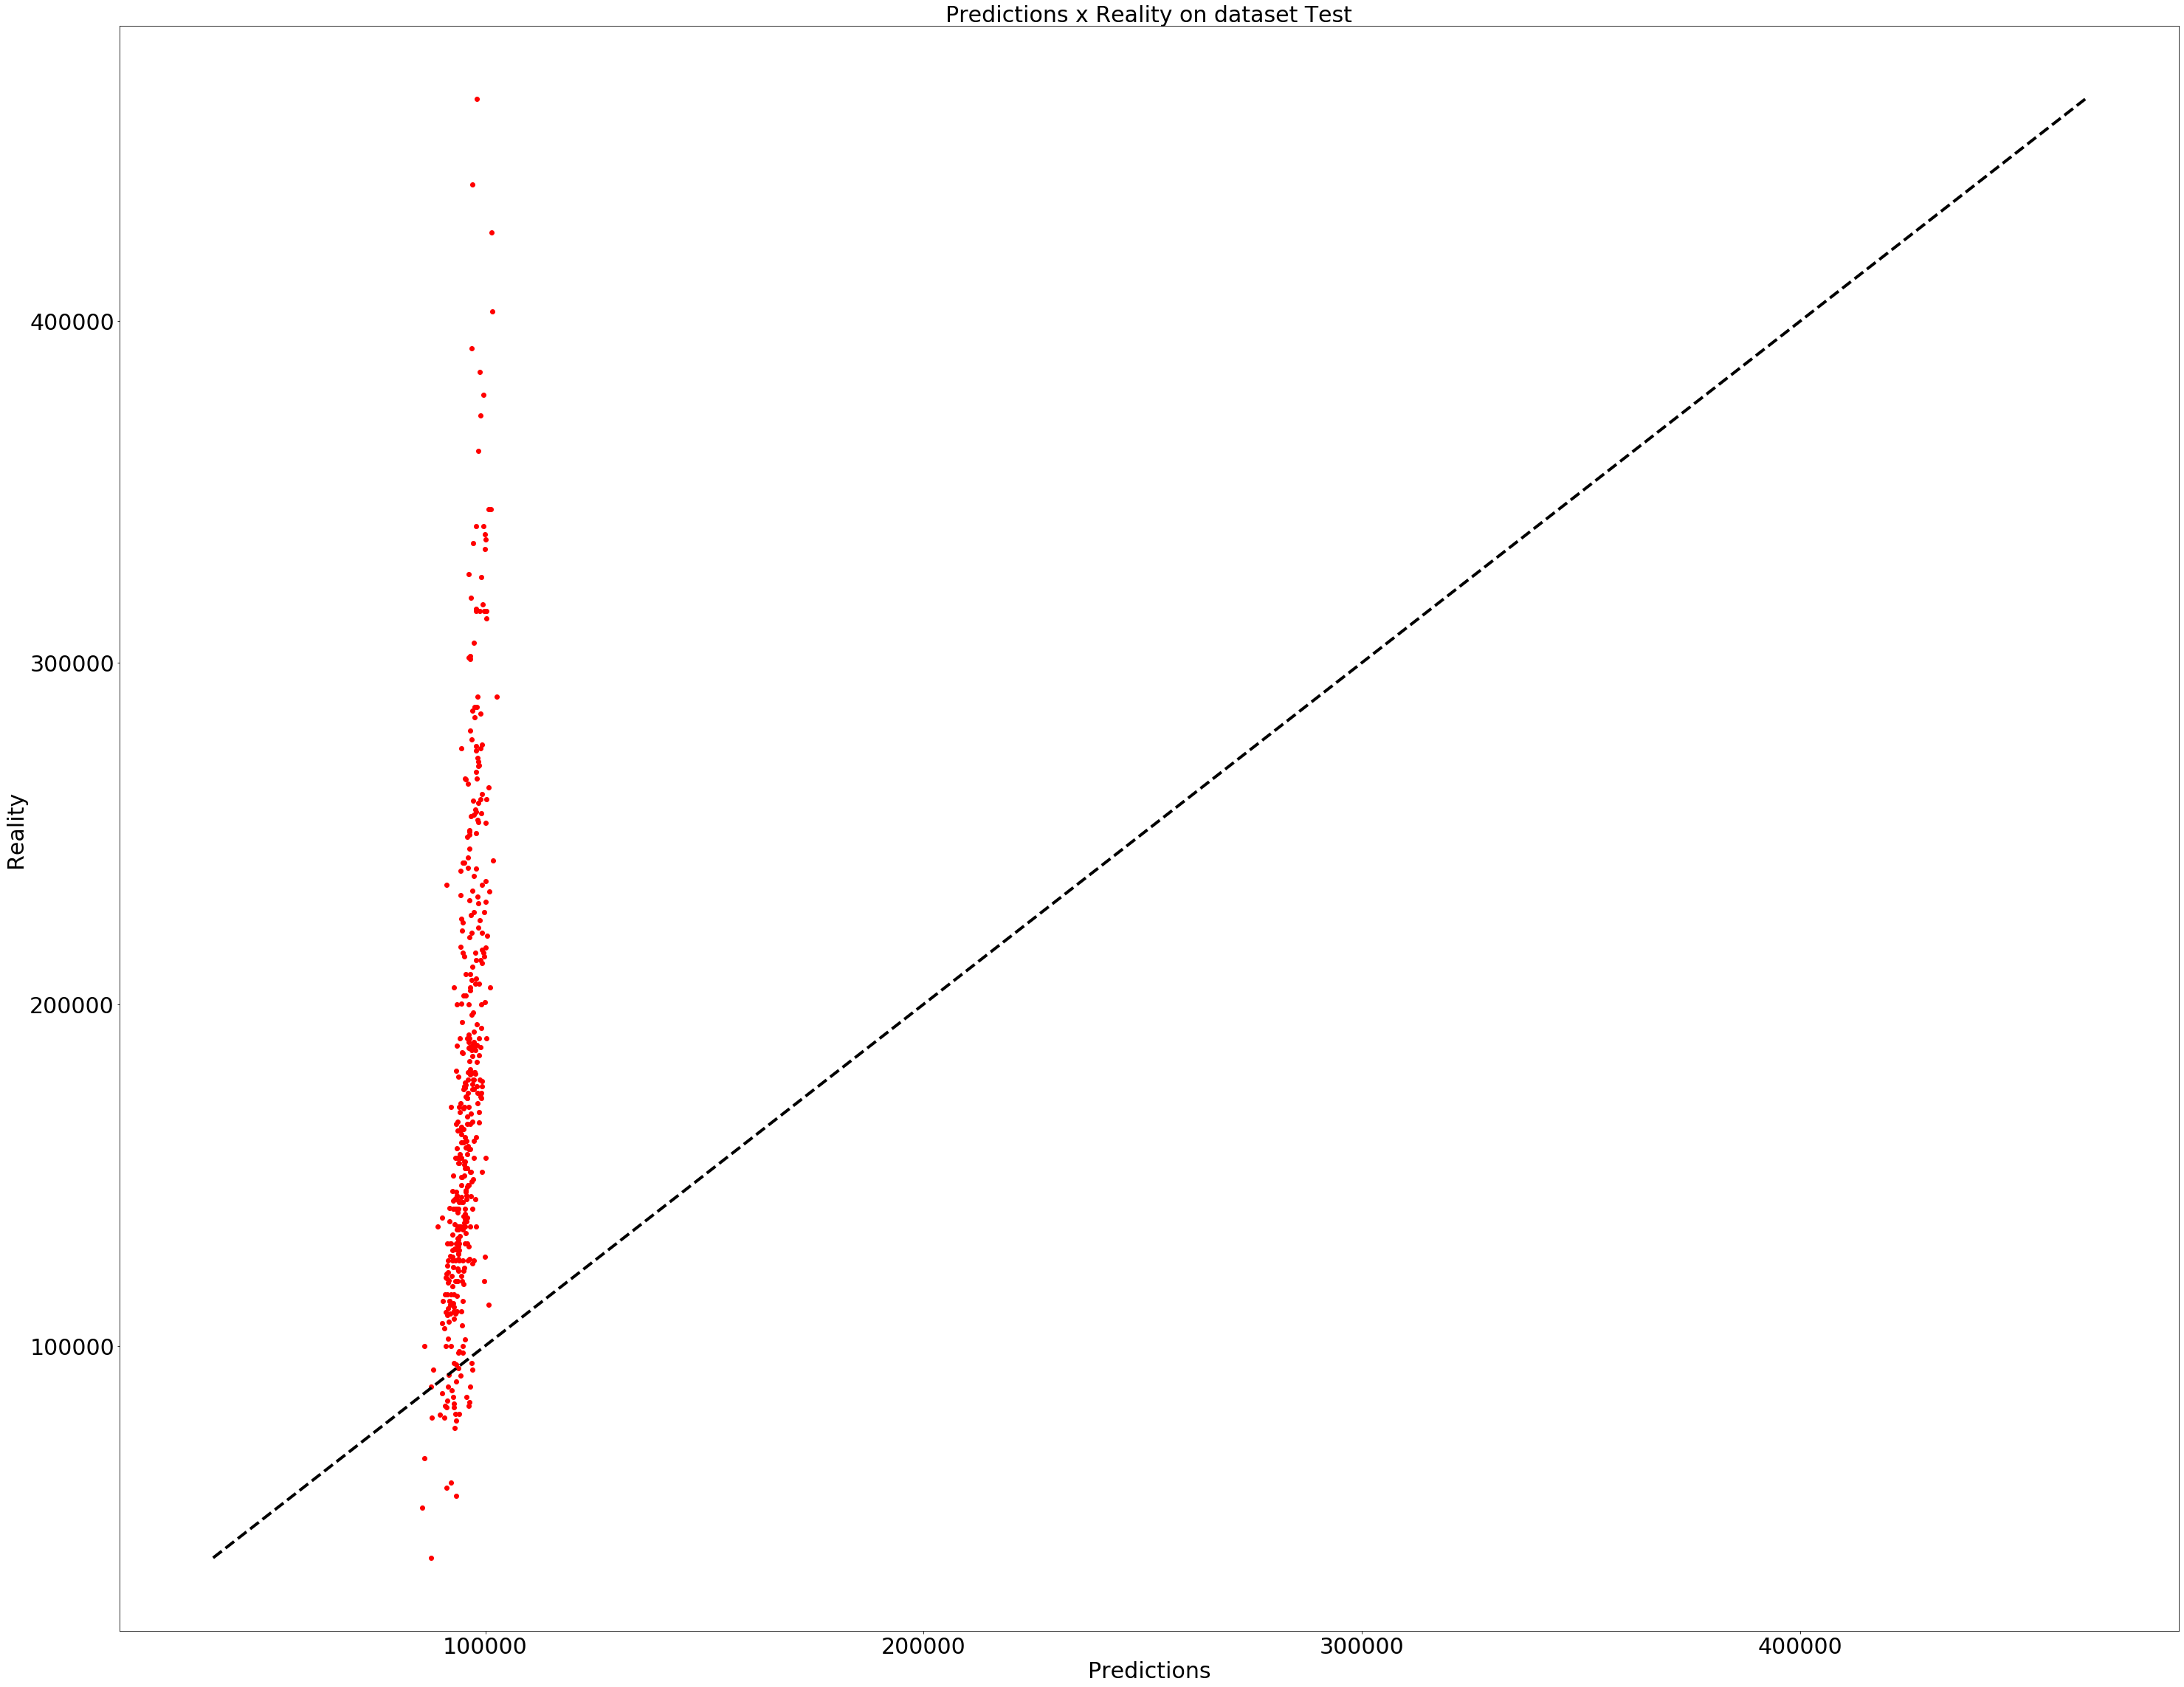

In [17]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions, reality, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [18]:
y_predict = model.predict(np.array(test))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['SalePrice'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "submission_continuous")